In [943]:
import pandas as pd 
import numpy as np
import scipy.stats
import pylab 
import matplotlib.pyplot as plt 
import statsmodels.graphics.tsaplots as sgt
from statsmodels.tsa.seasonal import seasonal_decompose 
import statsmodels.tsa.stattools as sts 
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.arima.model import ARIMA
from scipy.stats.distributions import chi2
from pmdarima.arima import auto_arima
import seaborn as sns

sns.set_style("darkgrid")
sns.mpl.rc("figure", figsize=(16, 6))
sns.mpl.rc("font", size=14)

### Import Digester 15 data

In [944]:
data15 = pd.read_csv("~/Documents/Data/NNRB/Finaldata/NN_Dataset.csv")
data15.head()

,Time,Delta,Damkohler,Alpha,Sigma,CUM_Steam
0,0,0.292234,1.682447,1.702603,0.010174,25.2
1,10,0.351944,1.628414,1.694305,0.011146,26.9
2,20,0.345074,1.634916,1.695156,0.011095,27.9
3,30,0.350893,1.627947,1.694981,0.010691,28.6
4,40,0.312540,1.664536,1.699610,0.010515,25.3


<Axes: >

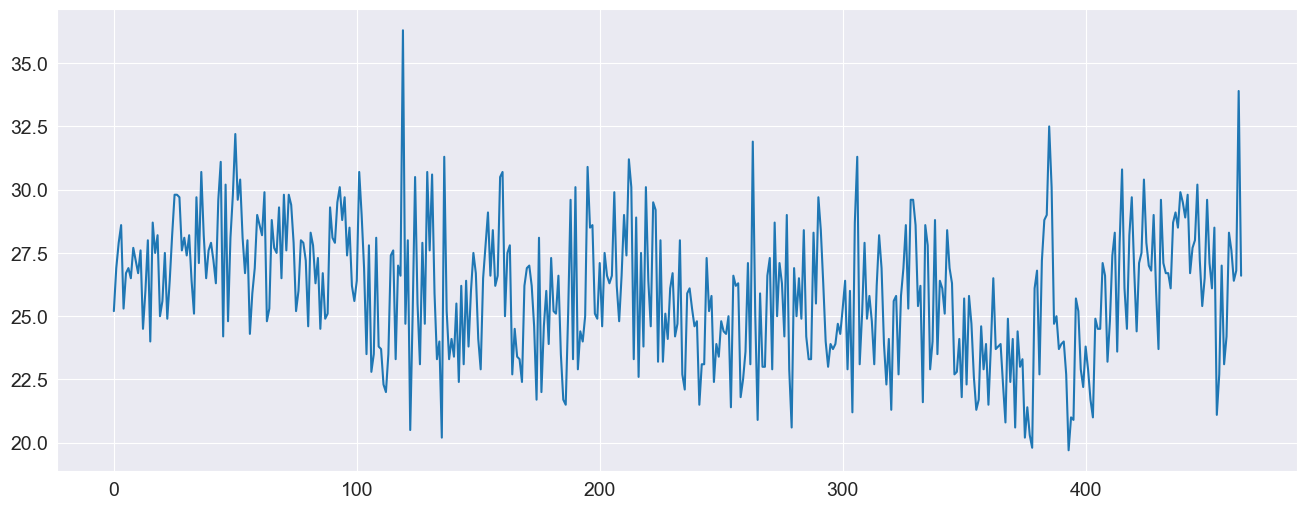

In [945]:
data15.CUM_Steam.plot()

## QQ Plot

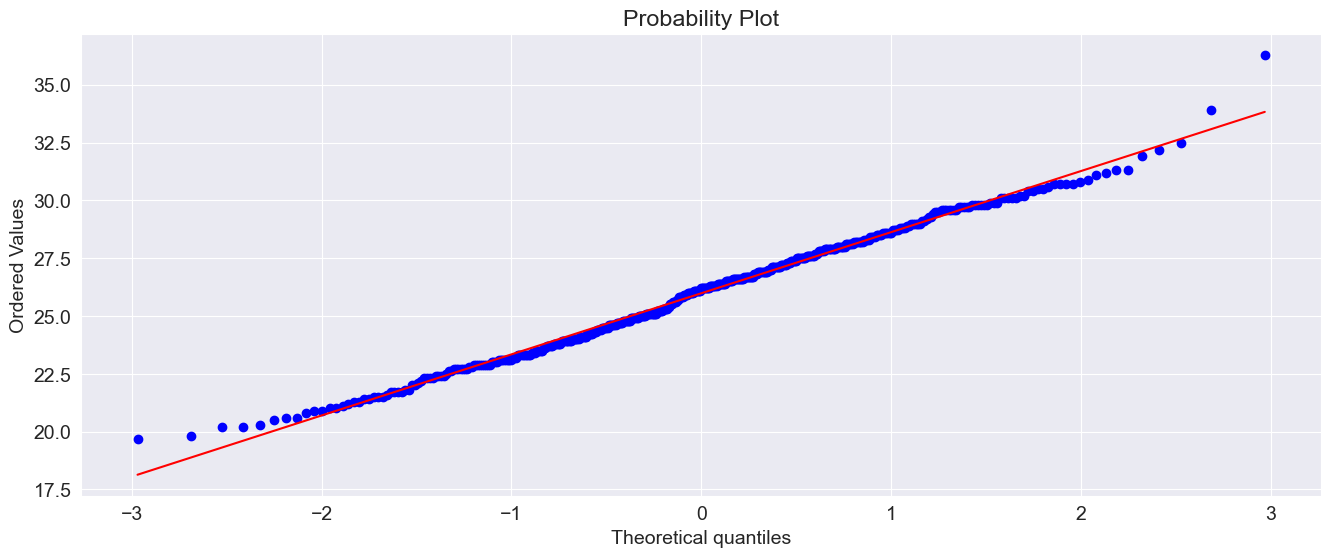

In [946]:
scipy.stats.probplot(data15.CUM_Steam, plot=pylab)
pylab.show()

In [947]:
data15.Time.describe()

count     465.000000
mean     2320.000000
std      1343.781976
min         0.000000
25%      1160.000000
50%      2320.000000
75%      3480.000000
max      4640.000000
Name: Time, dtype: float64

In [948]:
# Create a range of integers representing the time axis from 0 to 500
time_axis = range(0, len(data15))  # Assuming inclusive range from 0 to 500

# Multiply each integer by 60 to convert it to minutes
minutes = [t * 60 for t in time_axis]

# Convert the minutes to datetime format with 1-minute frequency
time_index = pd.date_range(start='2023-01-01', periods=len(minutes), freq='T')

# Assign the datetime index to the DataFrame
data15.index = time_index

# Drop the existing 'time' column
data15.drop(columns=['Time'], inplace=True)

# Rename the index to 'time'
data15.index.name = 'Time'

# Drop the existing 'Time' column if needed
data15_comp = data15.copy()

In [949]:
data15.head()

,Delta,Damkohler,Alpha,Sigma,CUM_Steam
Time,,,,,
2023-01-01 00:00:00,0.292234,1.682447,1.702603,0.010174,25.2
2023-01-01 00:01:00,0.351944,1.628414,1.694305,0.011146,26.9
2023-01-01 00:02:00,0.345074,1.634916,1.695156,0.011095,27.9
2023-01-01 00:03:00,0.350893,1.627947,1.694981,0.010691,28.6
2023-01-01 00:04:00,0.312540,1.664536,1.699610,0.010515,25.3


In [950]:
train_size = int(len(data15_comp)*0.8)

data15_train = data15_comp[:train_size]
data15_test = data15_comp[train_size:]

In [951]:
data15_train.tail()

,Delta,Damkohler,Alpha,Sigma,CUM_Steam
Time,,,,,
2023-01-01 06:07:00,0.162984,1.808034,1.717028,0.007553,20.8
2023-01-01 06:08:00,0.284202,1.546029,1.757060,0.009287,24.9
2023-01-01 06:09:00,0.255708,1.559549,1.765075,0.009103,22.4
2023-01-01 06:10:00,0.281896,1.679968,1.708506,0.009549,24.1
2023-01-01 06:11:00,0.216204,1.664368,1.744237,0.008519,20.6


In [952]:
data15_test.head

<bound method NDFrame.head of                         Delta  Damkohler     Alpha     Sigma  CUM_Steam
Time                                                                   
2023-01-01 06:12:00  0.056411   1.900245  1.733659  0.008691       24.4
2023-01-01 06:13:00  0.254040   1.721848  1.705858  0.008499       23.0
2023-01-01 06:14:00  0.166604   1.797362  1.719536  0.009210       23.3
2023-01-01 06:15:00  0.175149   1.796405  1.715559  0.007416       20.2
2023-01-01 06:16:00  0.224679   1.749593  1.709470  0.008048       21.4
2023-01-01 06:17:00  0.208336   1.650213  1.752991  0.008541       20.3
2023-01-01 06:18:00  0.165068   1.806193  1.716747  0.007839       19.8
2023-01-01 06:19:00  0.577909   1.413733  1.666399  0.011298       26.1
2023-01-01 06:20:00  0.307404   1.605343  1.724539  0.009513       26.8
2023-01-01 06:21:00  0.378827   1.603403  1.690611  0.009668       22.7
2023-01-01 06:22:00  0.356157   1.620878  1.695129  0.010438       27.2
2023-01-01 06:23:00  0.494693   1.

### Stationarity

In [953]:
sts.adfuller(data15_comp.CUM_Steam)

(-4.759509380404178,
 6.49627020900863e-05,
 6,
 458,
 {'1%': -3.4447087976702284,
  '5%': -2.867871300049488,
  '10%': -2.5701423432047443},
 2070.6125251471035)

### ACF

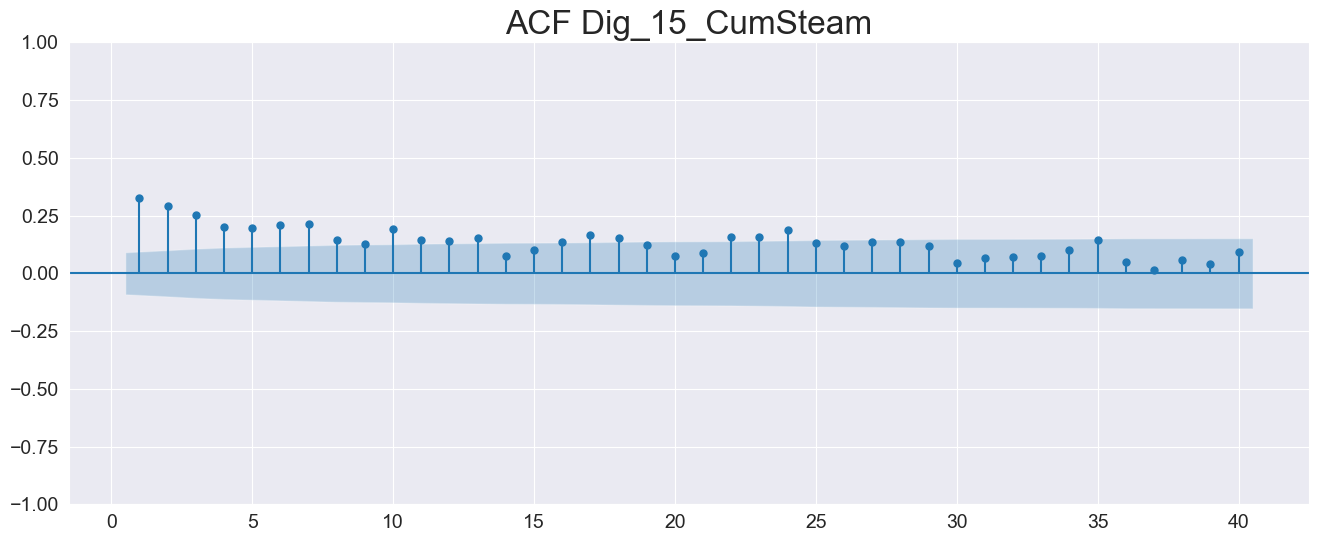

In [954]:
sgt.plot_acf(data15.CUM_Steam, lags = 40, zero = False)
plt.title("ACF Dig_15_CumSteam", size = 24)
plt.show()

### PACF

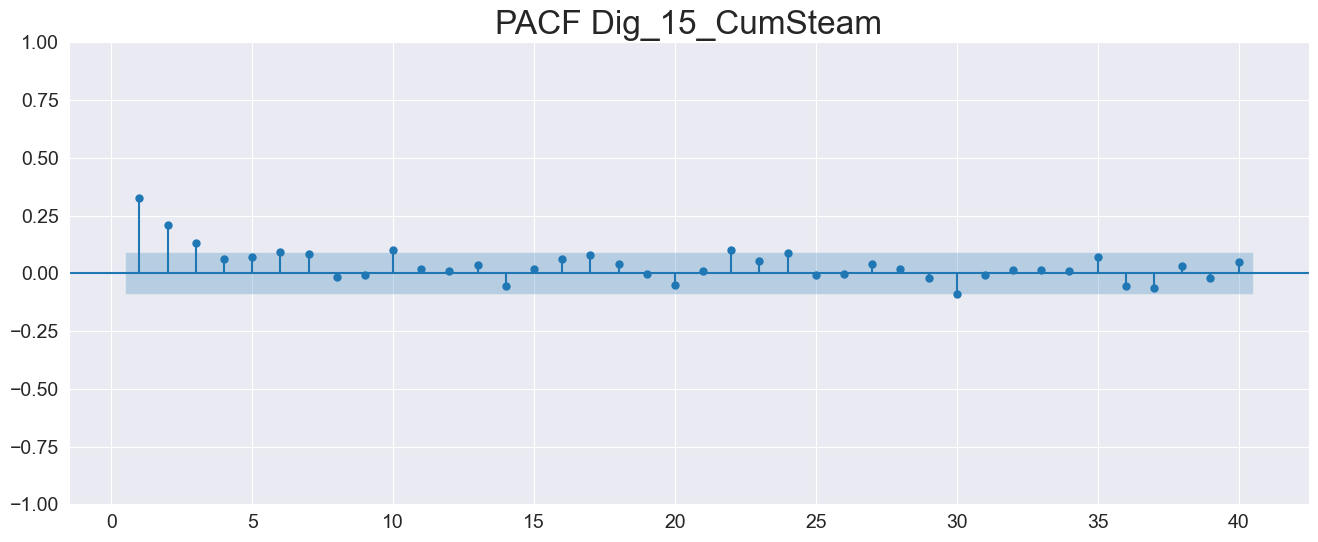

In [955]:
sgt.plot_pacf(data15.CUM_Steam, lags = 40, zero = False, method = ('ols'))
plt.title("PACF Dig_15_CumSteam", size = 24)
plt.show()

In [956]:
#LLR Test
def LLR_test(mod_1, mod_2, DF=1):
    L1 = mod_1.fit().llf
    L2 = mod_2.fit().llf
    LR = (2*(L2-L1))
    p = chi2.sf(LR, DF).round(3)

    return p

### AR Models

In [957]:
#AR1
model_ar1 = ARIMA(data15_train.CUM_Steam, order=(1, 0, 0))
results_ar1 = model_ar1.fit()
print(results_ar1.summary())

                               SARIMAX Results                                
Dep. Variable:              CUM_Steam   No. Observations:                  372
Model:                 ARIMA(1, 0, 0)   Log Likelihood                -865.113
Date:                Sat, 24 Feb 2024   AIC                           1736.227
Time:                        19:07:57   BIC                           1747.983
Sample:                    01-01-2023   HQIC                          1740.896
                         - 01-01-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         25.9756      0.172    151.202      0.000      25.639      26.312
ar.L1          0.2427      0.049      4.922      0.000       0.146       0.339
sigma2         6.1294      0.459     13.342      0.0

In [958]:
#AR2
model_ar2 = ARIMA(data15_train.CUM_Steam, order=(2, 0, 0))
results_ar2 = model_ar2.fit()
print(results_ar2.summary())
print("LLR test: " + str(LLR_test(model_ar1, model_ar2)))

                               SARIMAX Results                                
Dep. Variable:              CUM_Steam   No. Observations:                  372
Model:                 ARIMA(2, 0, 0)   Log Likelihood                -855.966
Date:                Sat, 24 Feb 2024   AIC                           1719.932
Time:                        19:07:57   BIC                           1735.608
Sample:                    01-01-2023   HQIC                          1726.158
                         - 01-01-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         25.9685      0.215    120.602      0.000      25.546      26.391
ar.L1          0.1899      0.049      3.849      0.000       0.093       0.287
ar.L2          0.2199      0.049      4.495      0.0

In [959]:
#AR3
model_ar3 = ARIMA(data15_train.CUM_Steam, order=(3, 0, 0))
results_ar3 = model_ar3.fit()
print(results_ar3.summary())
print("LLR test: " + str(LLR_test(model_ar2, model_ar3)))

                               SARIMAX Results                                
Dep. Variable:              CUM_Steam   No. Observations:                  372
Model:                 ARIMA(3, 0, 0)   Log Likelihood                -854.487
Date:                Sat, 24 Feb 2024   AIC                           1718.974
Time:                        19:07:59   BIC                           1738.569
Sample:                    01-01-2023   HQIC                          1726.756
                         - 01-01-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         25.9646      0.236    110.014      0.000      25.502      26.427
ar.L1          0.1706      0.051      3.345      0.001       0.071       0.271
ar.L2          0.2033      0.049      4.139      0.0

In [981]:
#ARMA
model_arma21 = ARIMA(data15_train.CUM_Steam, order=(2, 0, 2))
results_arma = model_arma21.fit()
print(results_arma.summary())

                               SARIMAX Results                                
Dep. Variable:              CUM_Steam   No. Observations:                  372
Model:                 ARIMA(2, 0, 2)   Log Likelihood                -846.806
Date:                Sun, 25 Feb 2024   AIC                           1705.612
Time:                        18:32:31   BIC                           1729.125
Sample:                    01-01-2023   HQIC                          1714.950
                         - 01-01-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         25.8228      0.628     41.100      0.000      24.591      27.054
ar.L1         -0.0170      0.033     -0.515      0.606      -0.082       0.048
ar.L2          0.9674      0.032     30.343      0.0

c:\Users\USER\Documents\ARMods\linvenv\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [977]:
#ARMA
model_arma11 = ARIMA(data15_train.CUM_Steam, order=(1, 0, 1))
results_arma = model_arma11.fit()
print(results_arma.summary())
print("LLR test: " + str(LLR_test(model_arma21, model_arma11)))

                               SARIMAX Results                                
Dep. Variable:              CUM_Steam   No. Observations:                  372
Model:                 ARIMA(1, 0, 1)   Log Likelihood                -847.213
Date:                Sun, 25 Feb 2024   AIC                           1702.426
Time:                        18:20:42   BIC                           1718.102
Sample:                    01-01-2023   HQIC                          1708.651
                         - 01-01-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         25.8291      0.627     41.217      0.000      24.601      27.057
ar.L1          0.9750      0.021     45.545      0.000       0.933       1.017
ma.L1         -0.8743      0.041    -21.325      0.0

In [978]:
#************************** ARIMA 111 IS THE CORRECT MODEL ******************************#

#ARIMA111

model_arima111 = ARIMA(data15_train.CUM_Steam, order=(1, 1, 1))
results_arima111 = model_arima111.fit()
print(results_arima111.summary())
print("LLR test: " + str(LLR_test(model_arima111, model_arma11)))

                               SARIMAX Results                                
Dep. Variable:              CUM_Steam   No. Observations:                  372
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -846.484
Date:                Sun, 25 Feb 2024   AIC                           1698.967
Time:                        18:24:22   BIC                           1710.716
Sample:                    01-01-2023   HQIC                          1703.634
                         - 01-01-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0486      0.058      0.842      0.400      -0.065       0.162
ma.L1         -0.9202      0.024    -37.884      0.000      -0.968      -0.873
sigma2         5.5876      0.393     14.235      0.0

In [980]:
#ARIMA
model_arima121 = ARIMA(data15_train.CUM_Steam, order=(1, 2, 1))
results_arima121 = model_arima121.fit()
print(results_arima111.summary())
print("LLR test: " + str(LLR_test(model_arima111, model_arima121)))

                               SARIMAX Results                                
Dep. Variable:              CUM_Steam   No. Observations:                  372
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -846.484
Date:                Sun, 25 Feb 2024   AIC                           1698.967
Time:                        18:30:28   BIC                           1710.716
Sample:                    01-01-2023   HQIC                          1703.634
                         - 01-01-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0486      0.058      0.842      0.400      -0.065       0.162
ma.L1         -0.9202      0.024    -37.884      0.000      -0.968      -0.873
sigma2         5.5876      0.393     14.235      0.0

### ARIMAX

In [994]:
# Define exogenous variables
exog_vars = data15_train[['Delta', 'Damkohler', 'Alpha', 'Sigma']]

# Fit AutoARIMA model with exogenous variables
model_arimax = ARIMA(data15_train['CUM_Steam'], exog=exog_vars, order=(1,1,1))  # Modify 'm' based on the seasonality of your data
res_arimax = model_arimax.fit()
res_arimax.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:              CUM_Steam   No. Observations:                  372
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -701.211
Date:                Sun, 25 Feb 2024   AIC                           1416.422
Time:                        19:14:16   BIC                           1443.835
Sample:                    01-01-2023   HQIC                          1427.310
                         - 01-01-2023                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Delta        118.1810    116.700      1.013      0.311    -110.546     346.908
Damkohler     91.0014     91.480      0.995      0.320     -88.295     270.298
Alpha        226.9561    243.737      0.931      0.352    -250.759     704.671
Sigma       1242.5121     59.017     21.053      0.000    1126.841    1358.184
ar.L1          0.0981      0.060      1.634      0.102      -0.020       0.216
ma.L1         -0.9305      0.020    -47.063      0.000      -0.969      -0.892
sigma2         2.5531      0.191     13.365      0.000       2.179       2.927
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):                 0.65
Prob(Q):                              0.92   Prob(JB):                         0.72
Heteroskedasticity (H):               0.79   Skew:                             0.09
Prob(H) (two-sided):                  0.19   Kurtosis:                         3.08
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

### Model Plotting

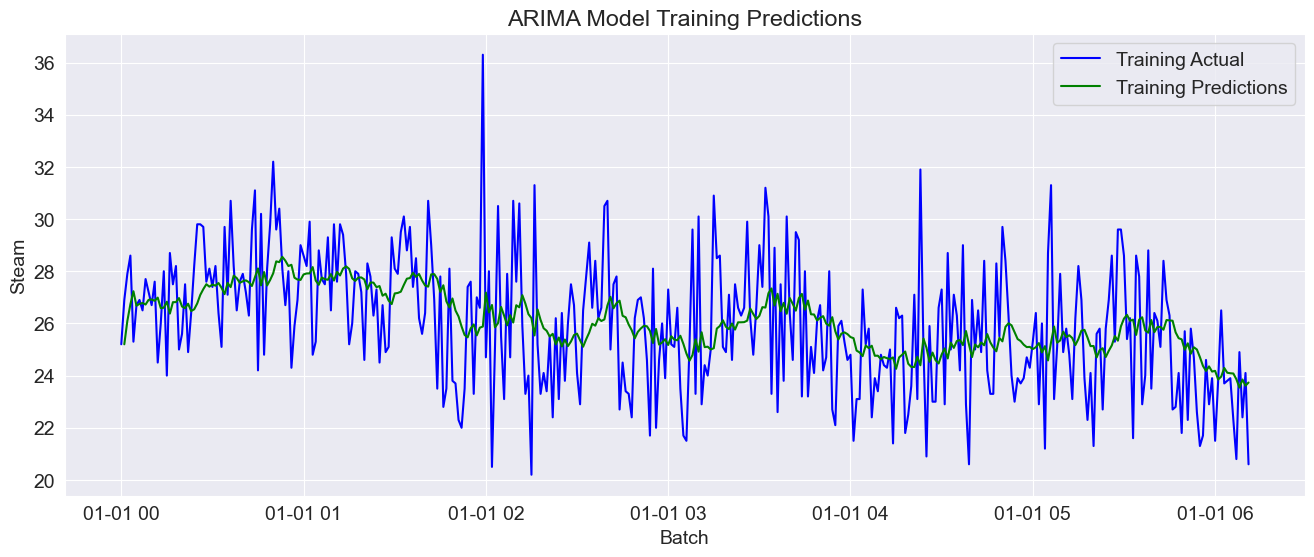

In [990]:
start_date = '2023-01-01 06:12:00'
end_date = '2023-01-01 07:44:00'

# Make predictions on training dataset
train_predictions = pd.DataFrame(results_arima111.predict())
#print(train_predictions)

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

#Make predictions on test dataset
test_predictions = pd.DataFrame(results_arima111.predict(start=start_date, end=end_date))
#print(test_predictions)

# Plot actual values of training data
plt.plot(data15_train.index, data15_train['CUM_Steam'], color='blue', label='Training Actual')

# Plot predicted values of training data
plt.plot(data15_train.index[1:], train_predictions['predicted_mean'].iloc[1:], color='green', label='Training Predictions')

# Add labels and legend
plt.title('ARIMA Model Training Predictions')
plt.xlabel('Batch')
plt.ylabel('Steam')
plt.legend()

# Show plot
plt.show()

### Training Performance

In [989]:
# Calculate Mean Absolute Error (MAE)
mae = mean_absolute_error(data15_train['CUM_Steam'], train_predictions['predicted_mean'])

# Calculate Root Mean Squared Error (RMSE)
rmse = np.sqrt(mean_squared_error(data15_train['CUM_Steam'], train_predictions['predicted_mean']))

# Calculate Accuracy (optional, depending on the problem)
accuracy = (1 - (mae / np.mean(data15_train['CUM_Steam']))) * 100
print('mae', mae)
print('rmse', rmse)
print('accuracy', accuracy)

mae 1.9569423202429472
rmse 2.700013381547528
accuracy 92.4677695254956


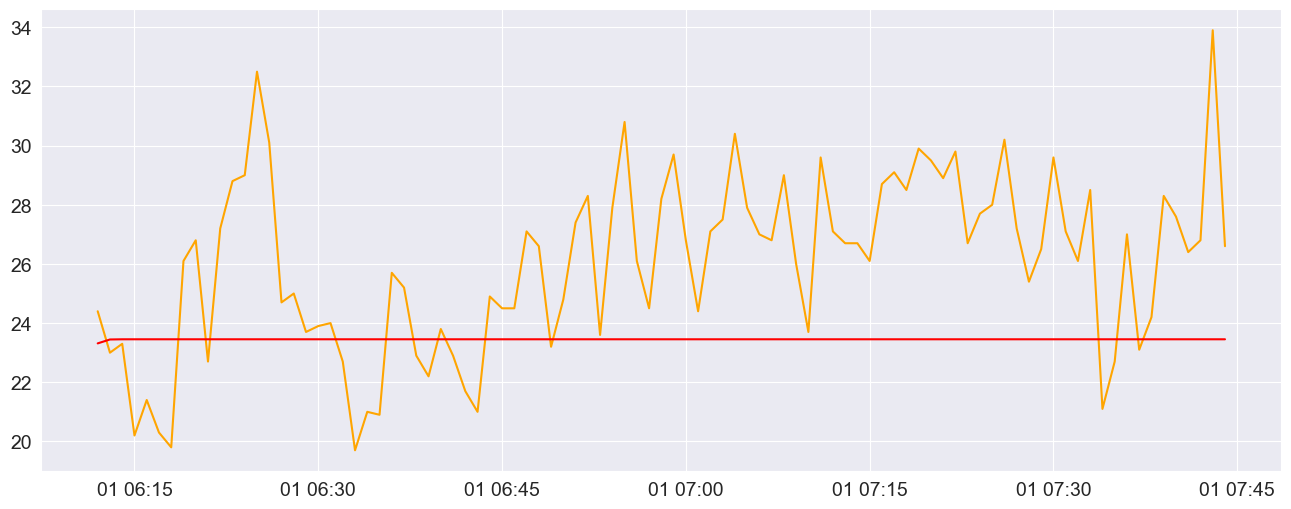

In [991]:
# Plot test data
plt.plot(data15_test.index, data15_test['CUM_Steam'], color='orange', label='Test')

# Plot forecasted values of test data
plt.plot(data15_test.index, test_predictions['predicted_mean'], color='red', label='Forecast')

# Show plot
plt.show()

### Test Performance

In [992]:
# Calculate Mean Absolute Error (MAE)
mae = mean_absolute_error(data15_test['CUM_Steam'], test_predictions['predicted_mean'])

# Calculate Root Mean Squared Error (RMSE)
rmse = np.sqrt(mean_squared_error(data15_test['CUM_Steam'], test_predictions['predicted_mean']))

# Calculate Accuracy (optional, depending on the problem)
accuracy = (1 - (mae / np.mean(data15_test['CUM_Steam']))) * 100
print('mae', mae)
print('rmse', rmse)
print('accuracy', accuracy)

mae 3.2488101448482087
rmse 3.8915725941465342
accuracy 87.49733743809966


### ARIMAX Model Plotting

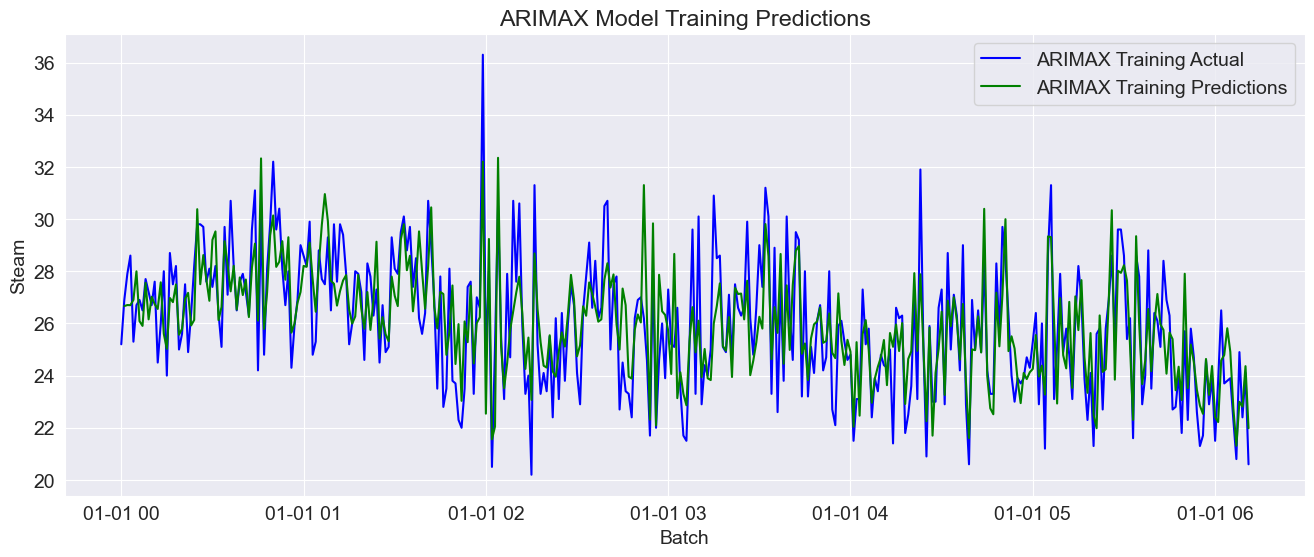

In [1000]:
start_date = '2023-01-01 06:12:00'
end_date = '2023-01-01 07:44:00'
exog_vars_test = data15_test[['Delta', 'Damkohler', 'Alpha', 'Sigma']]

# Make predictions on training dataset
train_predictions = pd.DataFrame(res_arimax.predict())
#print(train_predictions)

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

#Make predictions on test dataset
arimax_test_predictions = pd.DataFrame(res_arimax.predict(start=start_date, end=end_date, exog=exog_vars_test))
#print(test_predictions)

# Plot actual values of training data
plt.plot(data15_train.index, data15_train['CUM_Steam'], color='blue', label='ARIMAX Training Actual')

# Plot predicted values of training data
plt.plot(data15_train.index[1:], train_predictions['predicted_mean'].iloc[1:], color='green', label='ARIMAX Training Predictions')

# Add labels and legend
plt.title('ARIMAX Model Training Predictions')
plt.xlabel('Batch')
plt.ylabel('Steam')
plt.legend()

# Show plot
plt.show()

### ARIMAX Training Performance

In [999]:
# Calculate Mean Absolute Error (MAE)
mae = mean_absolute_error(data15_test['CUM_Steam'], test_predictions['predicted_mean'])

# Calculate Root Mean Squared Error (RMSE)
rmse = np.sqrt(mean_squared_error(data15_test['CUM_Steam'], test_predictions['predicted_mean']))

# Calculate Accuracy (optional, depending on the problem)
accuracy = (1 - (mae / np.mean(data15_test['CUM_Steam']))) * 100
print('mae', mae)
print('rmse', rmse)
print('accuracy', accuracy)

mae 1.6678957793987512
rmse 2.0004787793205345
accuracy 93.58129986410313


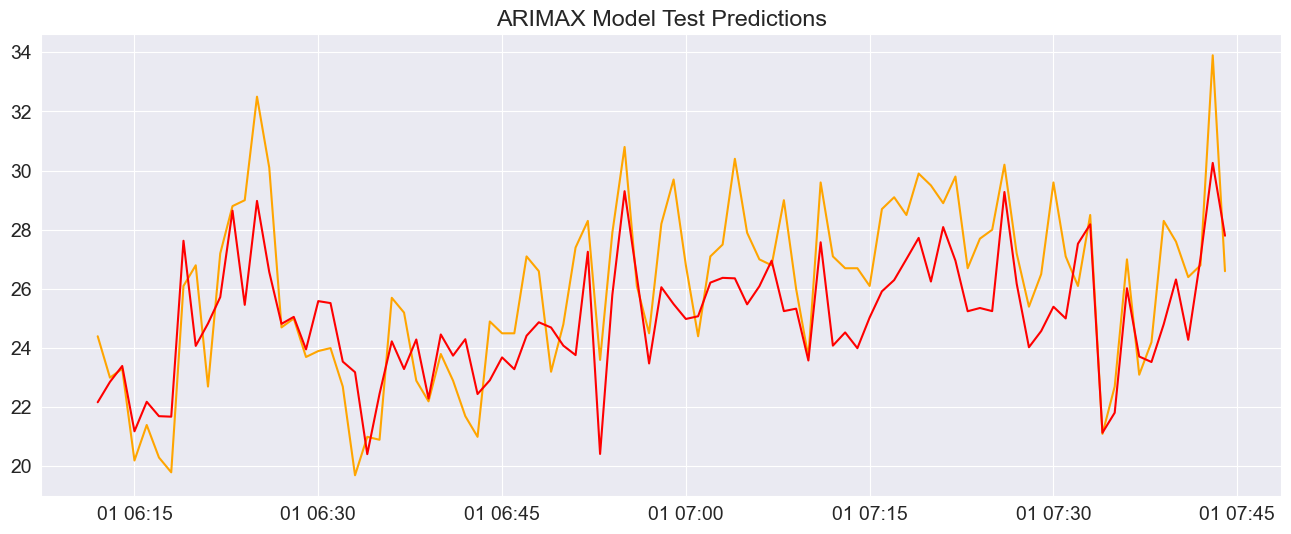

In [1001]:
# Plot test data
plt.plot(data15_test.index, data15_test['CUM_Steam'], color='orange', label='Test')

# Plot forecasted values of test data
plt.plot(data15_test.index, arimax_test_predictions['predicted_mean'], color='red', label='Forecast')

# Add labels and legend
plt.title('ARIMAX Model Test Predictions')

# Show plot
plt.show()

### ARIMAX Test Performance

In [1002]:
# Calculate Mean Absolute Error (MAE)
mae = mean_absolute_error(data15_test['CUM_Steam'], arimax_test_predictions['predicted_mean'])

# Calculate Root Mean Squared Error (RMSE)
rmse = np.sqrt(mean_squared_error(data15_test['CUM_Steam'], arimax_test_predictions['predicted_mean']))

# Calculate Accuracy (optional, depending on the problem)
accuracy = (1 - (mae / np.mean(data15_test['CUM_Steam']))) * 100
print('mae', mae)
print('rmse', rmse)
print('accuracy', accuracy)

mae 1.6678957793987512
rmse 2.0004787793205345
accuracy 93.58129986410313
